In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse.linalg
import random

Importing data

In [4]:

data = pd.read_csv('./data.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data.csv'

Constructing data matrices for three digits (0, 6, 9)

In [ ]:
A = np.array(data)

X_true = A[:,1:].T
Y_true = A[:,0]

In [ ]:
def x_split(X, Y, N_train):
    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest


Xtrain, Xtest, Ytrain, Ytest = x_split(X_true, Y_true, 30000)    

Implementing PCA

In [ ]:
def PCA(X, Y, k, choosen_numbers = [0, 6, 9]):
    
    indeces = [index for index, elem in enumerate(Y) if elem in choosen_numbers]
    X = X[:, indeces]
    Y = Y[indeces]

    
    c_X = np.mean(X, axis=1)
    c_X = np.reshape(c_X, (len(c_X), 1))

    
    X_c = X - c_X

    
    U, s, VT = np.linalg.svd(X, full_matrices = False)

    
    U_k = np.resize(U, (len(U), k))

    
    Z_k = U_k.T @ X
    
    return Z_k, Y, U_k.T


Implementing LDA

In [ ]:

def c_k(X, Y, k):
    I = (Y==k)
    tmp_X = X[:, I]
    return np.mean(tmp_X, axis=1)


def is_pos(X):
    return np.all(np.linalg.eigvals(X) > 0)

def LDA(X, Y, k, choosen_numbers = [0, 6, 9]):
    
    if len(choosen_numbers) == 3:
        indeces_1 = (Y == choosen_numbers[0])
        indeces_2 = (Y == choosen_numbers[1])
        indeces_3 = (Y == choosen_numbers[2])
    else:
        raise Exception(f"Choosen Numbers must be 3, but {len(choosen_numbers)} where given.")
    
    
    X1 = X[:, indeces_1]
    Y1 = Y[indeces_1]

    X2 = X[:, indeces_2]
    Y2 = Y[indeces_2]

    X3 = X[:, indeces_3]
    Y3 = Y[indeces_3]

    
    X_join = np.concatenate((X1, X2, X3), axis=1)
    Y_join = np.concatenate((Y1, Y2, Y3))
    
    
    c_1 = c_k(X, Y, choosen_numbers[0])
    c_1 = np.reshape(c_1, (len(c_1), 1))
    c_2 = c_k(X, Y, choosen_numbers[1])
    c_2 = np.reshape(c_2, (len(c_2), 1))
    c_3 = c_k(X, Y, choosen_numbers[2])
    c_3 = np.reshape(c_3, (len(c_3), 1))

    
    global_c = np.mean(X_join, axis=1)
    global_c = np.reshape(global_c, (len(global_c),1))

    
    X1_c = X1 - c_1
    X2_c = X2 - c_2
    X3_c = X3 - c_3

    
    X_w = np.concatenate((X1_c, X2_c, X3_c), axis=1)
    
    
    S_w = np.dot(X_w, X_w.T)

    
    gX_1 = np.full( Xtrain.shape, c_1)
    gX_2 = np.full( Xtrain.shape, c_2)
    gX_3 = np.full( Xtrain.shape, c_3)

    
    gX = np.concatenate((gX_1, gX_2, gX_3), axis=1)

    
    gX_c = gX - global_c

    
    S_b = np.dot(gX_c, gX_c.T)

    L= []
    
    if is_pos(S_w):
        L = np.linalg.cholesky(S_w)
    else:
        tmp = S_w.copy()
        tmp += np.eye(S_w.shape[0])
        
        L = np.linalg.cholesky(tmp)

    
    L_inv = np.linalg.inv(L)
    simil_H = L_inv @ S_b @ L

    W = scipy.sparse.linalg.eigs(simil_H, k=k)[1]
    W = np.real(W)

    
    Q = L_inv.T @ W

    
    Z = Q.T @ X_join
    
    return Z, Y_join, Q.T

In [ ]:
def avg_centroid_dist(Z, c, three_dim=False):
    tmp = []
    c = np.array(c)
    c = np.reshape(c, (len(c), 1))
    if three_dim:
        for Z_coord in zip(Z[0, :], Z[1, :], Z[2, :]):
            Z_coord = np.array(Z_coord)
            Z_coord = np.reshape(Z_coord, (len(Z_coord), 1))
            tmp.append(np.linalg.norm((Z_coord - c))**2)
    else:
        for Z_coord in zip(Z[0, :], Z[1, :]):
            Z_coord = np.array(Z_coord)
            Z_coord = np.reshape(Z_coord, (len(Z_coord), 1))
            tmp.append(np.linalg.norm((Z_coord - c))**2)
    return np.mean(tmp)

Testing PCA and LDA and visualizing results

In [ ]:
def my_plot(X, Y, three_dim=False, c_dist=False):
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot()
    if three_dim:
        ax = fig.add_subplot(projection="3d")
        ax.scatter(X[0, :], X[1, :], X[2, :], c=Y)    
    else:
        ax.scatter(X[0,:], X[1,:], c=Y)
    ax.scatter(*(c_k(X, Y, 0)), marker="x", color="red")
    ax.scatter(*(c_k(X, Y, 6)), marker="x", color="red")
    ax.scatter(*(c_k(X, Y, 9)), marker="x", color="red")
    if c_dist:
        print(f"Average distance from centroid for digit 0 = {avg_centroid_dist(X, c_k(X, Y, 0), three_dim=three_dim)}")
        print(f"Average distance from centroid for digit 6 = {avg_centroid_dist(X, c_k(X, Y, 6), three_dim=three_dim)}")
        print(f"Average distance from centroid for digit 9 = {avg_centroid_dist(X, c_k(X, Y, 9), three_dim=three_dim)}")
    plt.show()


In [ ]:
Z_pca, Y_pca, _ = PCA(Xtrain, Ytrain, k=2)

In [ ]:
Z_pca_3, Y_pca_3, _ = PCA(Xtrain, Ytrain, k=3)

Average distance from centroid for digit 0 = 746.7235947438776
Average distance from centroid for digit 6 = 819.2256183994555
Average distance from centroid for digit 9 = 799.6707146301981


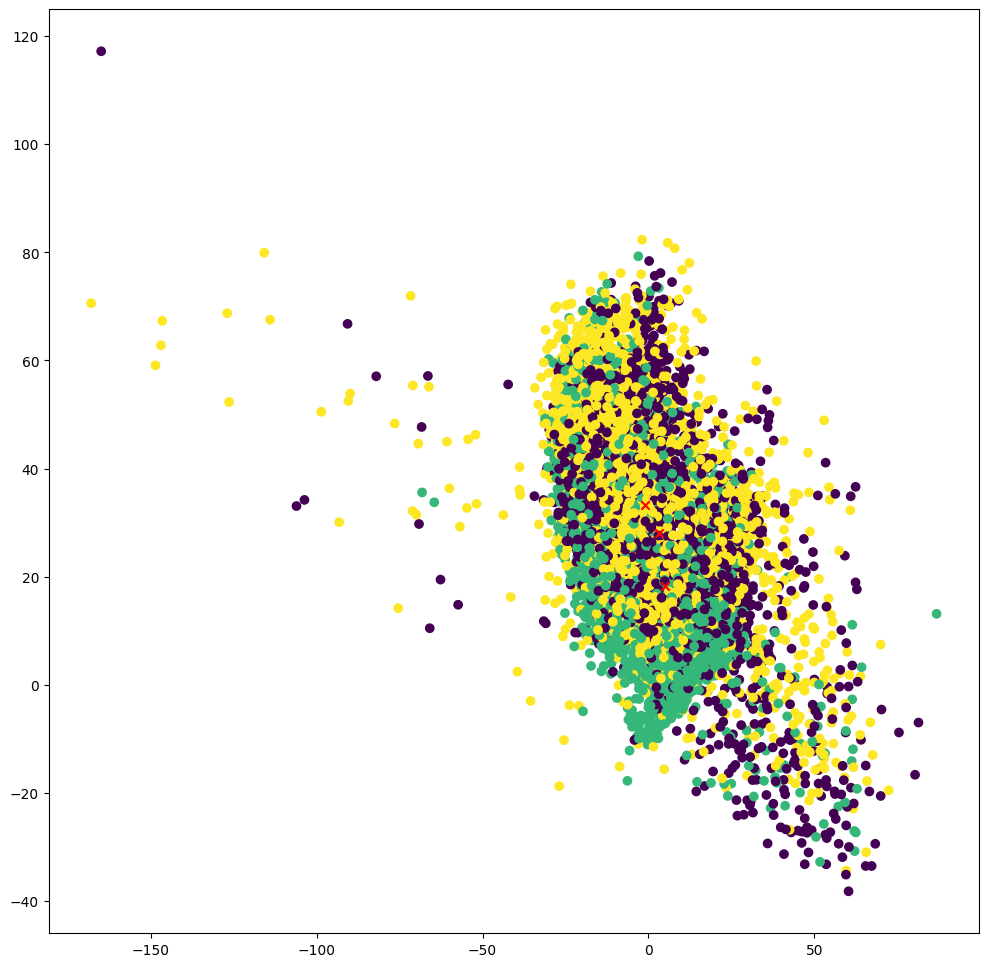

In [ ]:
my_plot(Z_pca, Y_pca, c_dist=True)

Average distance from centroid for digit 0 = 34363.71594678581
Average distance from centroid for digit 6 = 37317.7466143958
Average distance from centroid for digit 9 = 39630.51569530052


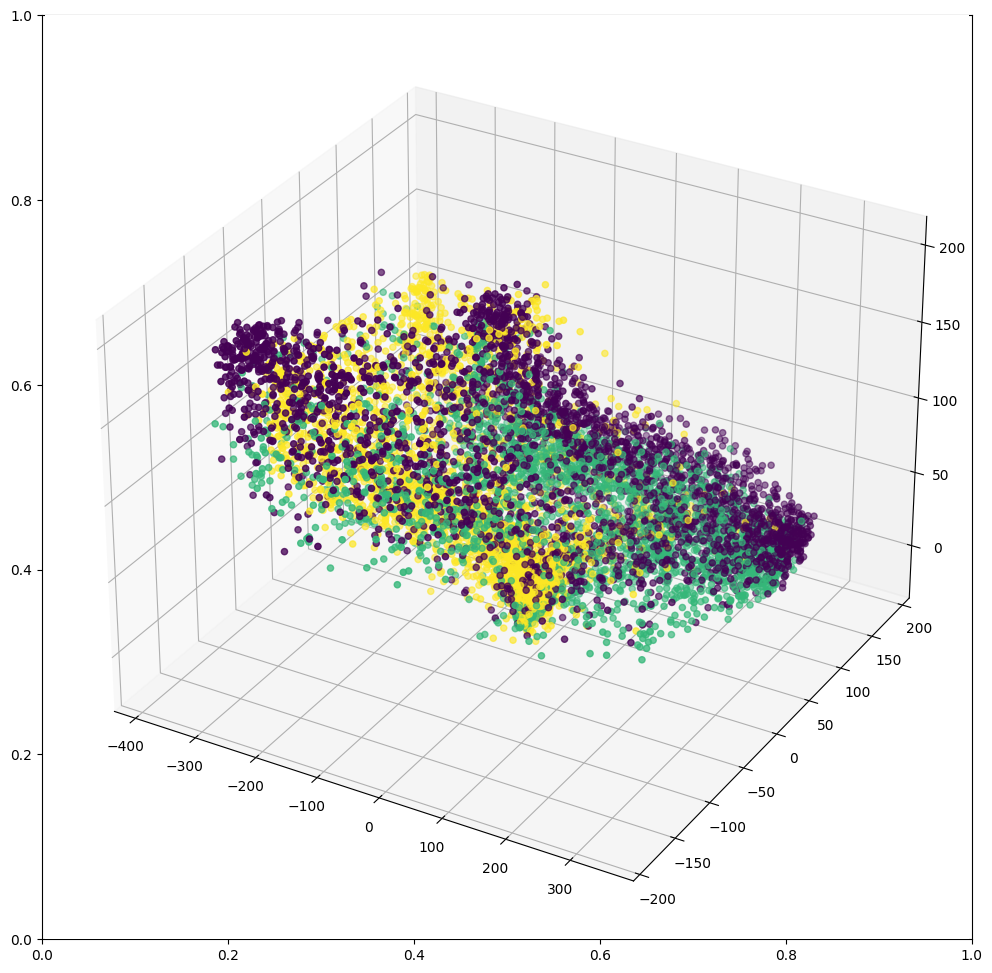

In [ ]:
my_plot(Z_pca_3, Y_pca_3, three_dim=True, c_dist=True)

In [ ]:
Z, Y_join, _ = LDA(Xtrain, Ytrain, k=2)

In [ ]:
Z_3, Y_join_3, _ = LDA(Xtrain, Ytrain, k=3)

Average distance from centroid for digit 0 = 0.0039405826363087945
Average distance from centroid for digit 6 = 0.003823206249144394
Average distance from centroid for digit 9 = 0.004906788729796304


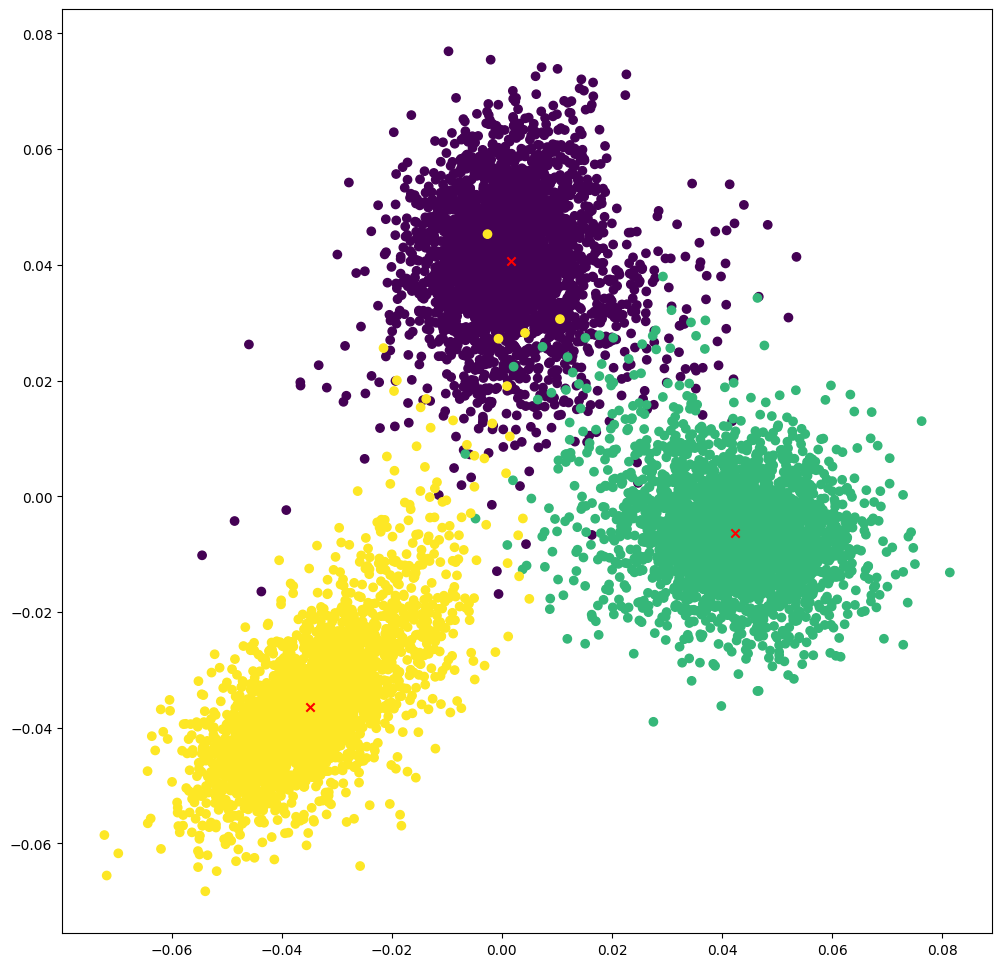

In [ ]:

my_plot(Z, Y_join, c_dist=True)

Average distance from centroid for digit 0 = 0.004053137395919538
Average distance from centroid for digit 6 = 0.003935487088943355
Average distance from centroid for digit 9 = 0.0050202725129837485


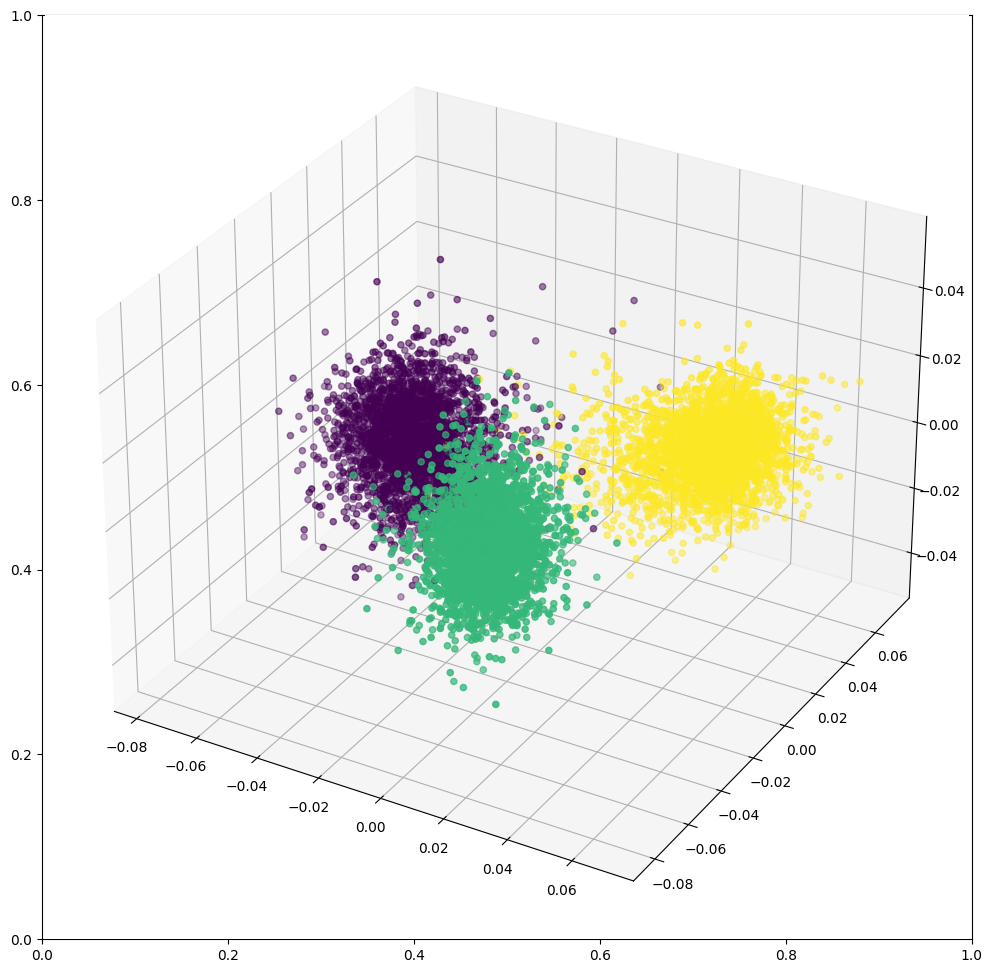

In [ ]:
my_plot(Z_3, Y_join_3, three_dim=True, c_dist=True)

In [ ]:
Z_test, Y_join_test, _ = LDA(Xtest, Ytest, k=2)

Average distance from centroid for digit 0 = 0.011625032083517884
Average distance from centroid for digit 6 = 0.011057444206316425
Average distance from centroid for digit 9 = 0.01469317563937877


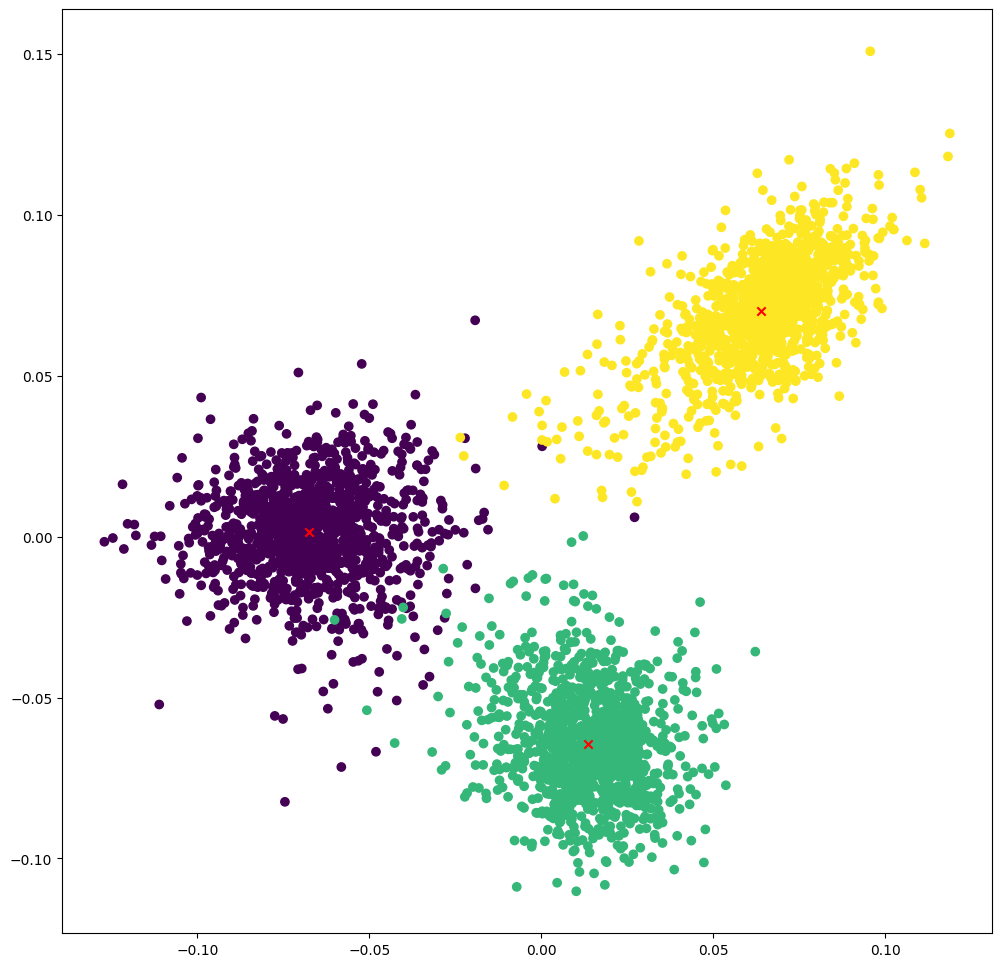

In [ ]:
my_plot(Z_test, Y_join_test, c_dist=True)

Classification

In [ ]:
choosen_numbers = [0, 6, 9]
indeces = [index for index, elem in enumerate(Ytest) if elem in choosen_numbers]
Xtest_fixed = Xtest[:, indeces]
Ytest_fixed = Ytest[indeces]

random_index = random.randint(0, len(indeces))
new_x = Xtest_fixed[:, random_index]
true_digit = Ytest_fixed[random_index]
print(true_digit)

6


In [ ]:
def classify(Z, Y, P, x):
    z = P @ x
    c_0 = c_k(Z, Y_join, 0)
    c_6 = c_k(Z, Y_join, 6)
    c_9 = c_k(Z, Y_join, 9)

    d_0 = np.linalg.norm((z - c_0))
    d_6 = np.linalg.norm((z - c_6))
    d_9 = np.linalg.norm((z - c_9))
    
    min = d_0
    if d_6 < min:
        if d_6 < d_9:
            return  choosen_numbers[1]
        else:
            return choosen_numbers[2]
    elif d_9 < min:
        if d_9 < d_6:
            return choosen_numbers[2]
        else:
            return choosen_numbers[1]
    else:
        return choosen_numbers[0]

In [ ]:
Z_pca, Y_pca, P_pca = PCA(Xtrain, Ytrain, k=2)
Z_pca_3, Y_pca_3, P_pca_3 = PCA(Xtrain, Ytrain, k=3)

In [ ]:
Z_lda, Y_lda, P_lda = LDA(Xtrain, Ytrain, k=2)
Z_lda_3, Y_lda_3, P_lda_3 = LDA(Xtrain, Ytrain, k=3)

In [ ]:
hitting = {"pca": 0, "pca_3": 0, "lda": 0, "lda_3": 0}
for index, elem in enumerate(Xtest_fixed.T):
    true_cluster = Ytest_fixed[index]
    if classify(Z_pca, Y_pca, P_pca, elem) == true_cluster:
        hitting["pca"]+=1
    if classify(Z_pca_3, Y_pca_3, P_pca_3, elem) == true_cluster:
        hitting["pca_3"]+=1
    if classify(Z_lda, Y_lda, P_lda, elem) == true_cluster:
        hitting["lda"]+=1
    if classify(Z_lda_3, Y_lda_3, P_lda_3, elem) == true_cluster:
        hitting["lda_3"]+=1

In [ ]:
accuracy = {"pca": 0, "pca_3": 0, "lda": 0, "lda_3": 0}
for idx in {"pca", "pca_3", "lda", "lda_3"}:
    accuracy[idx] = hitting[idx]/len(Xtest_fixed.T)*100

In [ ]:
print(hitting)
print(accuracy)

{'pca': 1192, 'pca_3': 993, 'lda': 3541, 'lda_3': 3535}
{'pca': 33.046853340726365, 'pca_3': 27.52980316052121, 'lda': 98.17022456334904, 'lda_3': 98.00388134183532}


<h1>Visualizing DYAD</h1>

In [ ]:
import skimage
import numpy as np

import matplotlib.pyplot as plt
import skimage.io
from skimage import data

In [ ]:
img = data.chelsea()[:, :, 1]


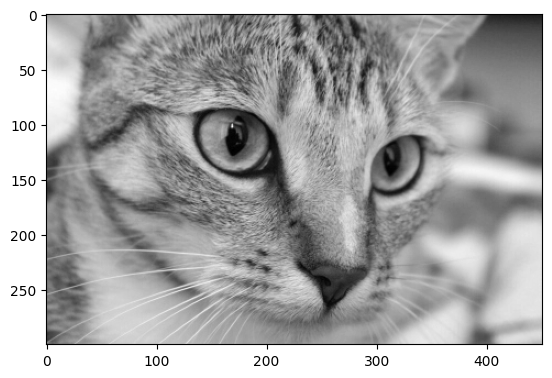

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
U, s, VT = np.linalg.svd(img, full_matrices = False)

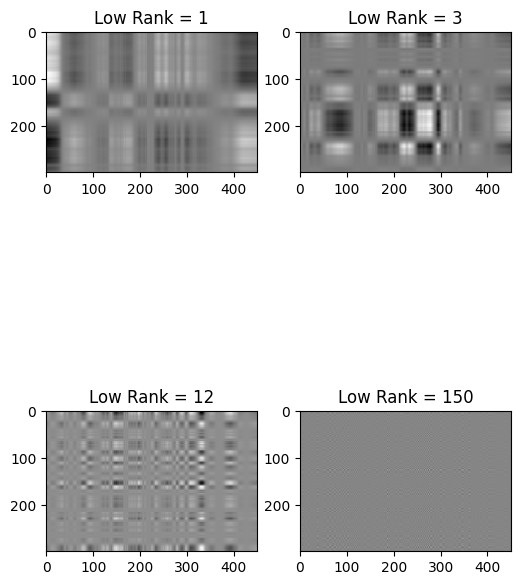

In [ ]:
indices = [1, 3, 12, 150]
fig = plt.figure(figsize = (4*img.shape[0]/200, 4*img.shape[1]/200))
rows = 2
columns = 2
j = 1
for i in indices:
    M_tmp = s[i] * np.outer(U.T[i], VT[i])
    fig.add_subplot(rows, columns, j).set_title("Low Rank = " + str(i))
    j+=1
    plt.imshow(M_tmp, cmap="gray")
plt.show()

In [ ]:
print([sv for sv in s])

[41308.42858057524, 5576.383506047912, 4354.477252545095, 3199.709513219122, 2955.0902593304445, 2619.6891998433034, 2301.5715287749267, 1878.3572250006262, 1760.6777916492438, 1714.0428596724305, 1444.936284240833, 1348.6353581060416, 1280.163729882838, 1256.4396519172283, 1123.387531451912, 1080.9241585010502, 991.317043374143, 964.8891009452345, 892.268969408108, 854.5629953875243, 820.9061626276884, 771.3347793160051, 749.0899473868152, 704.2772068951741, 633.7187230919791, 619.8969622622641, 602.5023078458329, 578.5759617117941, 560.4374295218408, 550.3061870224382, 527.6476924602771, 505.3788521700549, 497.46720510466986, 481.4336035399547, 475.60071285341434, 457.4702326825267, 443.3287721889408, 436.37961983521126, 425.46360411749026, 420.7215432031017, 416.4528219001583, 403.93768652718273, 395.15429178895073, 383.1845882411315, 379.9314916639518, 360.68764978638836, 353.3722491913094, 346.72991767575996, 341.2013276533448, 335.93592717602576, 327.05790342233985, 320.655792982

In [ ]:
def rank_approximation(U, s, VT, A = None, ks = [3, 15, 30, 170], toshow = True): 
    if len(ks) > 4 and toshow:
        raise Exception(f"A maximum number of 4 trials of approximation must be passed, but {len(ks)} were given") 
    if toshow:
        fig = plt.figure(figsize = (4*img.shape[0]/170, 4*img.shape[1]/170))
        rows = 2
        columns = 2
        j = 1
    errs = []
    for k in ks:   
        approx = s[0] * np.outer(U.T[0], VT[0])
        for i in range(1, k):
            approx += s[i] * np.outer(U.T[i], VT[i])
        
        if toshow:
            fig.add_subplot(rows, columns, j).set_title("Approximation with Rank = " + str(k))
            j+=1
            plt.imshow(approx, cmap="gray")
        
        if A is not None: 
            errs.append(np.linalg.norm(A - approx))
        else:
            errs = None
    if toshow:
        plt.show()
    return ks, errs

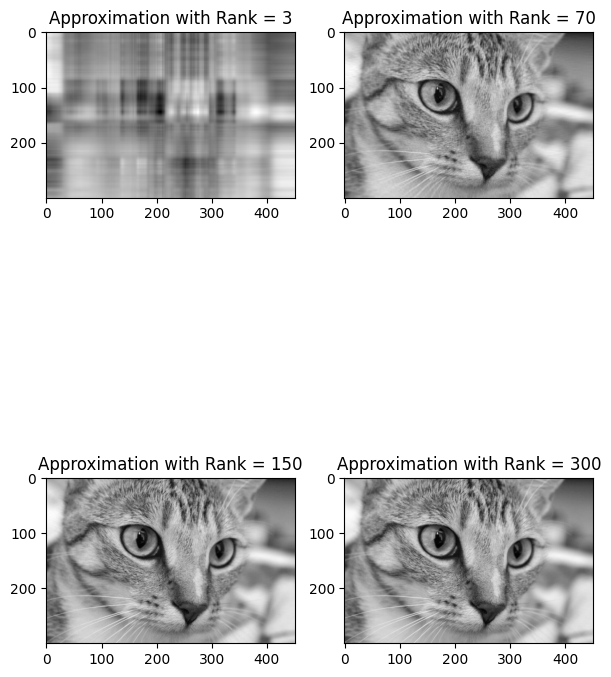

In [ ]:
ks, errs = rank_approximation(U, s, VT, img, ks=[3, 70, 150, 300])
ks_full, errs_full = rank_approximation(U, s, VT, img, ks=np.arange(start=1, stop=300), toshow=False)

In [ ]:
for item in zip(ks, errs):
    print(f"Error of {item[1]} with {item[0]}-rank approximation.")

Error of 8081.498441134487 with 3-rank approximation.
Error of 1432.2311363729689 with 70-rank approximation.
Error of 520.8644647073337 with 150-rank approximation.
Error of 1.1576830509210408e-10 with 300-rank approximation.


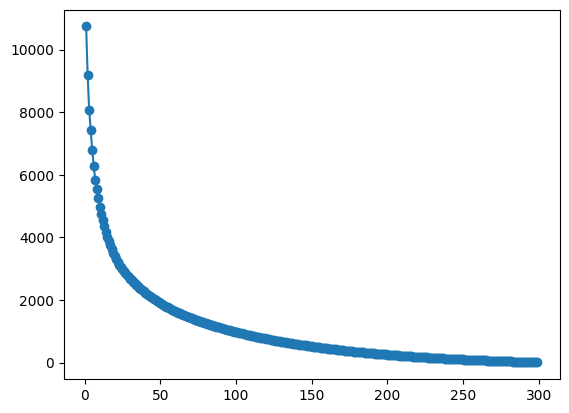

In [ ]:
plt.plot(ks_full, errs_full, '-o')

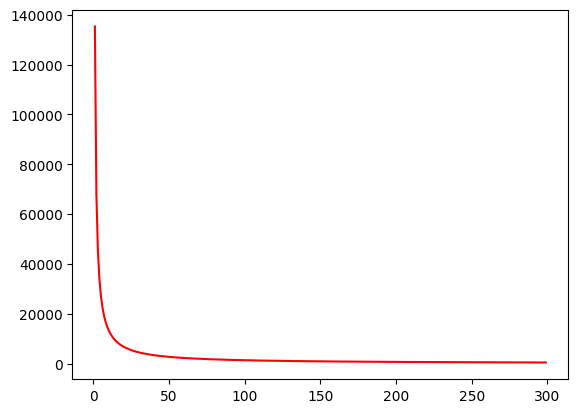

In [ ]:
def compr_factor(img, k):
    m, n = img.shape
    return k/(m*n)

plt.plot(ks_full, compr_factor(img, ks_full), '-r')